# Árvore de classificação II  - Resposta multinomial

*There is no greater insult than "you've created an elegant solution to an irrelevant problem."*    
D. J. Patil (Data Driven) 

**Árvore de classificação multinomial:** Cada nó da árvore pode ter mais de duas ramificações, sendo assim, a modelagem de decisão de mais de dois resultados se torna possível.

*Multinomial refere-se a uma extensão da distribuição binomial para mais de duas categorias. Descreve o resultado de experimentos em que há múltiplas categorias possíveis para cada evento.*

## 1 - Classificação multinomial - Parte I

In [6]:
# importando pacotes relevantes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

##### <span style='color:purple'>  Carregando banco de dados.

In [8]:
# Carregando dataset
penguins = sns.load_dataset('penguins')
print('--> Shape',penguins.shape)
penguins.head()

--> Shape (344, 7)


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


In [9]:
# Espécies dos pinguins
penguins.species.unique()

array(['Adelie', 'Chinstrap', 'Gentoo'], dtype=object)

In [10]:
# Dados faltantes
missing = penguins.isna().sum()
missing

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64

In [11]:
penguins[penguins['sex'].isna()]

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
8,Adelie,Torgersen,34.1,18.1,193.0,3475.0,NaN
9,Adelie,Torgersen,42.0,20.2,190.0,4250.0,NaN
10,Adelie,Torgersen,37.8,17.1,186.0,3300.0,NaN
11,Adelie,Torgersen,37.8,17.3,180.0,3700.0,NaN
47,Adelie,Dream,37.5,18.9,179.0,2975.0,NaN
246,Gentoo,Biscoe,44.5,14.3,216.0,4100.0,NaN
286,Gentoo,Biscoe,46.2,14.4,214.0,4650.0,NaN
324,Gentoo,Biscoe,47.3,13.8,216.0,4725.0,NaN
336,Gentoo,Biscoe,44.5,15.7,217.0,4875.0,NaN


### Descritiva inicial

Vamos fazer uma matriz de dispersão (scatterplot matrix) para visualizar o quão promissora é a classificação das raças de pinguim de acordo com as variáveis biométricas.

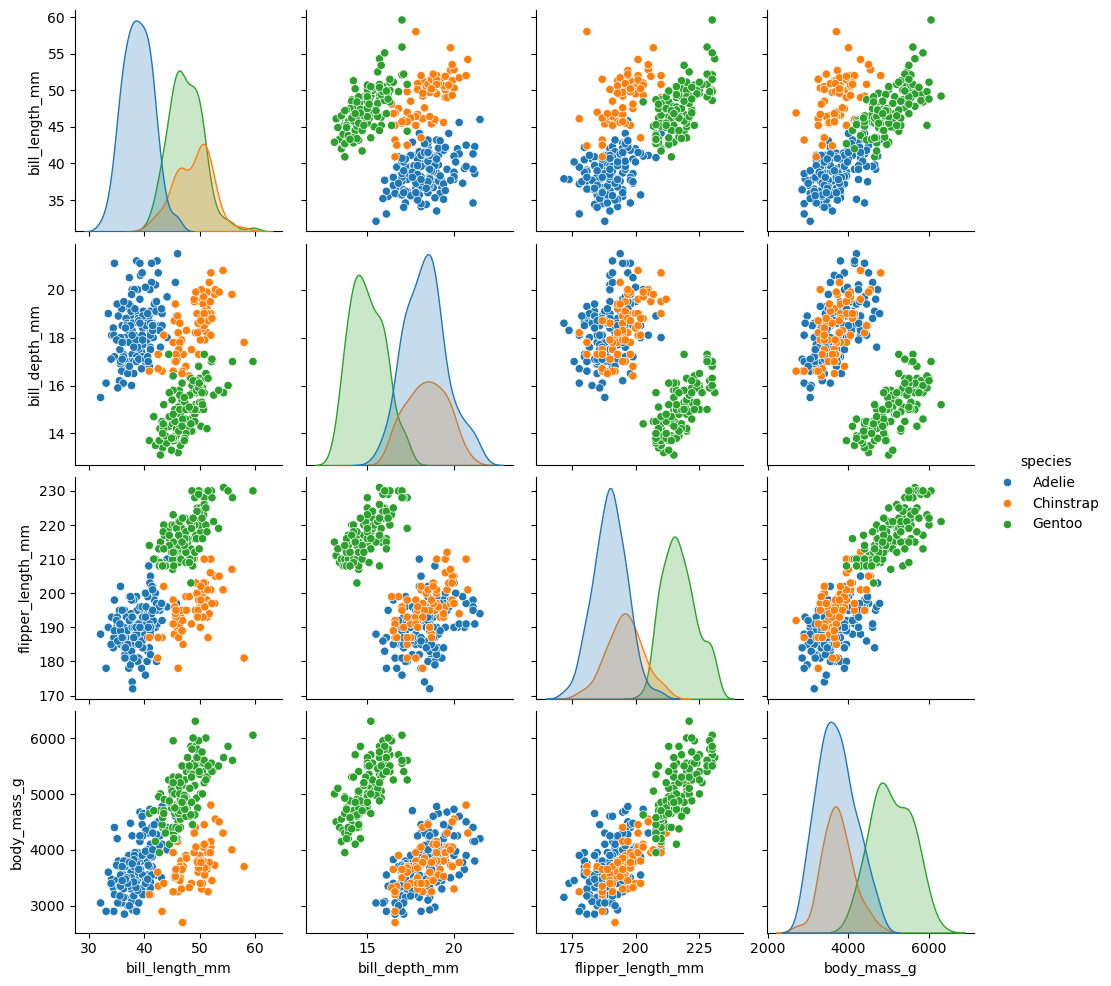

In [13]:
# Pairplot
sns.pairplot(penguins, hue='species')

In [14]:
# Avaliando os dados faltantes em função dos demais dados 
penguins[penguins['bill_depth_mm'].isna()]

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN


Quando a variáveil `bill_depth_mm` é um dado faltante, todos os demais são faltantes, exceto `species` e `island`. Dessa forma, descartar essas duas linhas é a melhor opção. 

In [16]:
peng = penguins[~penguins['bill_length_mm'].isna()].copy()
print(peng.shape)
peng.isna().sum()

(342, 7)


species              0
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
sex                  9
dtype: int64

### Preenchimento de dados faltantes

Para a variável ```sex```, temos mais 9 registros com dados faltantes. Claro que em se tratando de análise de dados, podemos ter inúmeras alternativas, mas eu vejo aqui três razoáveis com prós e contras:

- Eliminar a variável ```sex```. Essa alternativa pode significar abrir mão de uma fonte de varição importante que deve ajudar a classificar os indivíduos em suas respectivas classes.
- Eliminar os 9 registros faltantes: parece uma solução ok, mas já vamos para 11 registros eliminados de 344.
- Fazer imputação de dados: Isso significa tentar "adivinhar" qual o valor para a variável faltante para não perder o registro. Se fizermos isso mal, podemos introduzir ruído na base, por outro lado, recuperamos esses registros.

A terceira opção parece mais interessante. Agora... que método podemos utilizar? 
- Podemos fazer imputação pela moda - utilizar o valor que mais aparece na base.
- Imputação aleatória: simplemente sortear um valor conforme a distribuição observada
- Ou ainda, a solução que vamos adotar, fazer uma "imputação por árvore":
    - Vamos construir uma árvore de decisão para classificar o sexo dos pinguins dadas as demais variáveis
    - Em seguida vamos usar esta árvore para classificar os valores faltantes.

Se a nossa árvore for boa, vamos cometer um erro pequeno, e em todo caso, vamos "salvar" as observações com dados faltantes. Como contra, eu apontaria o trabalho de se construir esta árvore.

#### Análise descritiva: Vale a pena preencher `sex` com modelo?

É importante tentar entender se vale a pena criar a árvore. Para tal vamos analisar as características dos pinguins.

<Axes: xlabel='species', ylabel='bill_length_mm'>

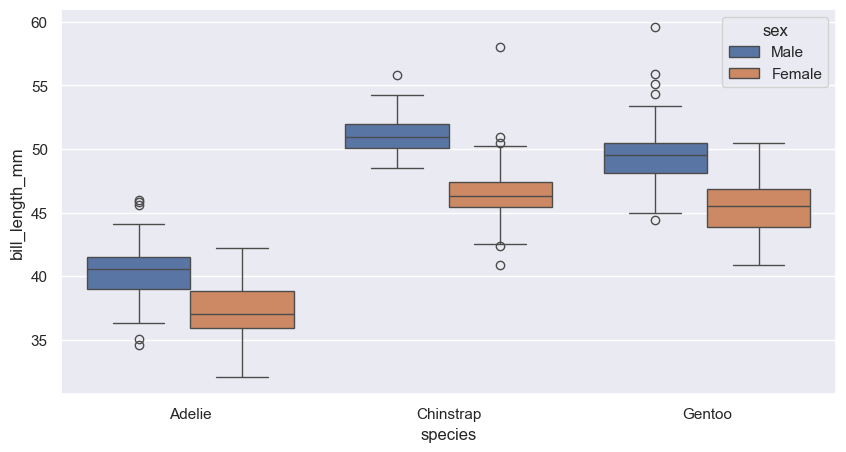

In [20]:
# Gerando um boxplot com relação ao sexo 

# sns.set_theme(style='ticks')
sns.set_theme(style='darkgrid')

plt.figure(figsize=[10, 5])
sns.boxplot(
    data=peng,
    x='species',
    y='bill_length_mm',
    hue='sex'
)

Como podemos notar, há uma diferença no tamanho do bico entre as espécies. Devido a isso, talvez consigamos gerar um modelo capaz de fazer um bom preenchimento dos dados faltantes.

#### Modelo de preenchimento

Vamos agora preparar a base de dados para criarmos um modelo de imputação de dados, **classificar o sexo**. 
- Vamos retirar a variável `sex` da base
- Utilizar o `get_dummies()` para criar as variáveis dummy de `species` e `island`
- Separar a base em treino e teste
- Fazer pós-poda pelo ccp_alpha
- Classificar a base original para não perder observações

##### <span style='color:purple'> Eliminando os dados faltantes (missing data) para construirmos o modelo.

In [24]:
# Criando uma nova base de dados
peng2 = peng[~peng['sex'].isna()] # Removendo os dados faltantes
print(peng2.shape)
peng2.head()

(333, 7)


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male


In [25]:
# Verificando dados faltantes
peng2.isna().sum()

species              0
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

##### <span style='color:purple'> Criando dummies e separando a base de dados em treino e teste

In [27]:
y0 = peng2.sex
x0 = pd.get_dummies(peng2.drop(columns = ['sex']), drop_first=True)

# drop_first --> False - parece facilitar a visualização dos dados (minha opinião)

In [28]:
x0.head(3)

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,species_Chinstrap,species_Gentoo,island_Dream,island_Torgersen
0,39.1,18.7,181.0,3750.0,False,False,False,True
1,39.5,17.4,186.0,3800.0,False,False,False,True
2,40.3,18.0,195.0,3250.0,False,False,False,True


In [29]:
y0.head(3)

0      Male
1    Female
2    Female
Name: sex, dtype: object

In [30]:
# Separando em treino e teste

x0_train, x0_test, y0_train, y0_test = train_test_split(x0, y0)

##### Construindo a árvore

Deixando a árvore o mais completa possível, sem limitações no número de observações, profundidade ou complexidade.

In [32]:
clf0 = DecisionTreeClassifier(random_state=42)
path = clf0.cost_complexity_pruning_path(x0_train, y0_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

##### Pós-poda

Sobre a árvore acima, que é super complexa, vamos obter árvores derivadas e menos complexas seguindo o caminho indicado pelo custo de complexidade (o *ccp alpha*). Para cada árvore derivada, vamos avaliar a métrica de desempenho (no caso, a acurácia), e escolher a melhor árvore para fazer a imputação. 

In [34]:
clfs0 = []
for ccp_alpha in ccp_alphas:
    clf0 = DecisionTreeClassifier(random_state=2360873, ccp_alpha=ccp_alpha).fit(x0_train, y0_train)
    clfs0.append(clf0)

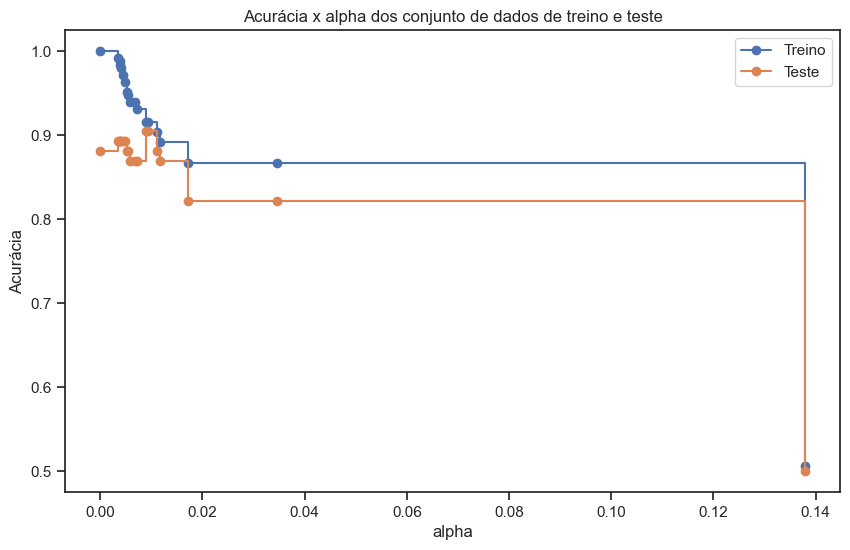

In [35]:
# Vamos gerar um gráfico com o objetivo de obeter as melhores métricas para o modelo (a árvore)

train_scores = [clf0.score(x0_train, y0_train) for clf0 in clfs0]
test_scores = [clf0.score(x0_test, y0_test) for clf0 in clfs0]

sns.set_theme(style='ticks')

fig, ax = plt.subplots(figsize=[10,6])
ax.set_xlabel('alpha')
ax.set_ylabel('Acurácia')
ax.set_title('Acurácia x alpha dos conjunto de dados de treino e teste')
ax.plot(ccp_alphas, train_scores, marker='o', label='Treino',
        drawstyle='steps-post')
ax.plot(ccp_alphas, test_scores, marker='o', label='Teste',
       drawstyle='steps-post')
plt.legend()
plt.show()

*Pronto. Abaixo tem uma "firula": Eu quero a melhor árvore, sim, mas se houverem empates, a que tenha a menor complexidade. Isso significa que eu quero pegar a maior métrica de desempenho no objeto test_scores, mas se houver empates, queremos a primeira ocorrência desse máximo da direita para a esquerda.*

In [37]:
ind_melhor_arvore = len(test_scores) - test_scores[::1].index(max(test_scores)) - 1
melhor_arvore = clfs0[ind_melhor_arvore]

In [38]:
ind_melhor_arvore

6

In [39]:
melhor_arvore

DecisionTreeClassifier(ccp_alpha=0.0048192771084337345, random_state=2360873)

##### Substituindo os missing

Agora que fizemos a árvore para a variável ```sex```, vamos utilizar esta regra para substituir os valores missing na base original. Aí você pode me perguntar: "Por quê não fazemos para as outras 4 variávels?" E eu respondo com outra pergunta: "Sério? Você acha mesmo que vale a pena por 2 observações e sem ter muito com o que prever? Boa sorte então, pode fazer!" Repito: sempre vale refletir se vale o esforço de se construir um modelo.

In [41]:
# Seleciona as variáveis a serem substituídas
prever = pd.get_dummies(peng.drop(columns=['sex']), drop_first=True)
prever_sex = prever[peng['sex'].isna()]

# Faz a classificação conforme a árvore
imputacao_sex = melhor_arvore.predict(prever_sex)
imputacao_sex

array(['Female', 'Male', 'Female', 'Female', 'Female', 'Female', 'Female',
       'Female', 'Female'], dtype=object)

In [42]:
# Fazendo a substituição
peng.loc[peng['sex'].isna(), 'sex'] = imputacao_sex

print(peng.shape)
peng.isna().sum()

(342, 7)


species              0
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

In [43]:
peng

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male
...,...,...,...,...,...,...,...
338,Gentoo,Biscoe,47.2,13.7,214.0,4925.0,Female
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female


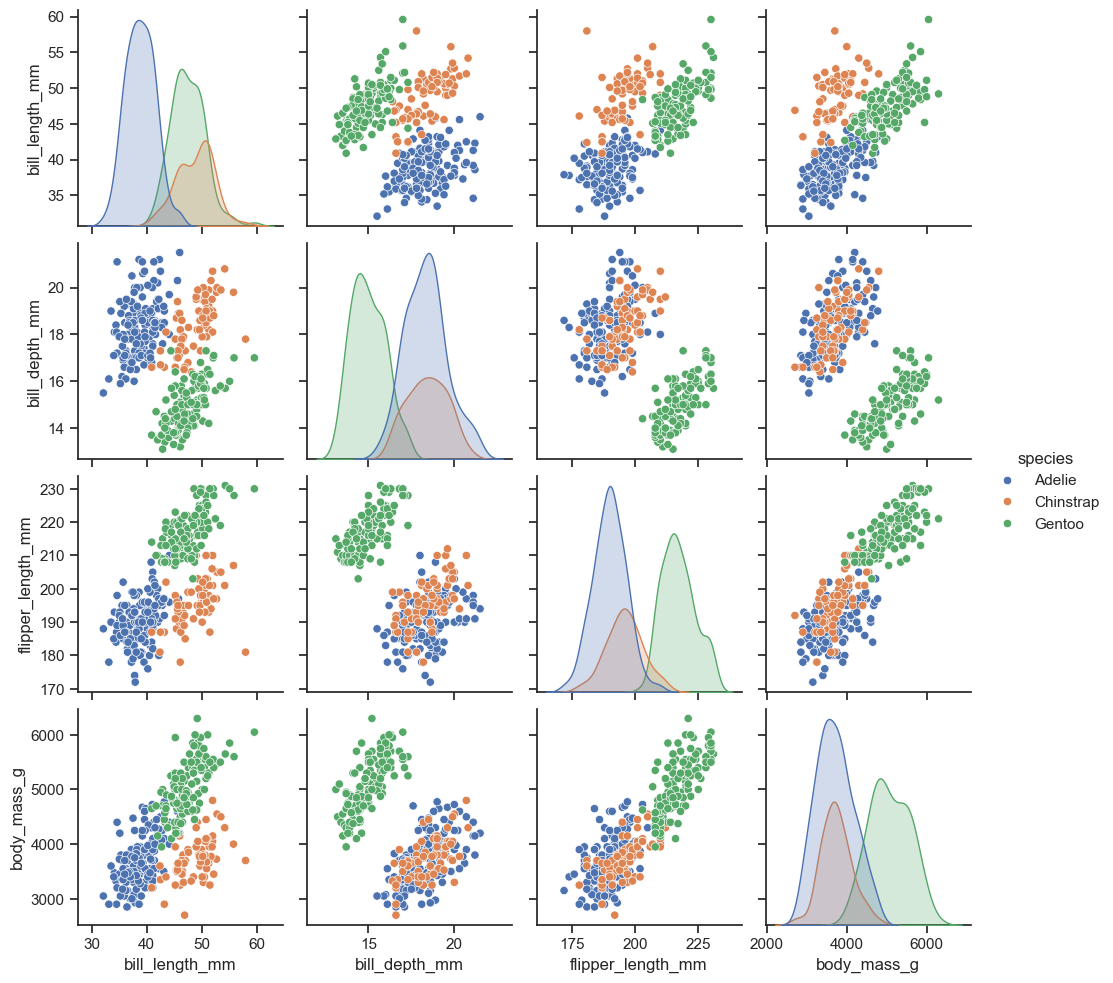

In [44]:
sns.set_theme(style='ticks')
sns.pairplot(peng, hue='species')

**Salvando a base de dados tratada para análises futuras.**

In [46]:
peng.to_csv('peng.csv', index=False)

## 2 - Classificação multinomial - Parte II

- Construção de uma árvore de classificação multinomial
- Aplicar custo de complexidade na poda da árvore
- Avaliar a qualidade da árvore de decisão usando uma matriz de confusão

Utilizaremos os dados tratados (Parte I)

In [49]:
peng.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male


In [50]:
# Separando em traino e teste

x = pd.get_dummies(peng.drop(columns=['species', 'island']), drop_first=True)
y = peng['species']

x_train, x_test, y_train, y_test = train_test_split(x, y)

In [51]:
y_train.value_counts()

species
Adelie       109
Gentoo        94
Chinstrap     53
Name: count, dtype: int64

#### Árvore

Árvore semelhante com o que já fizemos, mas com mais de uma alternativa de resposta.


In [53]:
clf = DecisionTreeClassifier(random_state=2360873, max_depth=3)
clf.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=2360873)

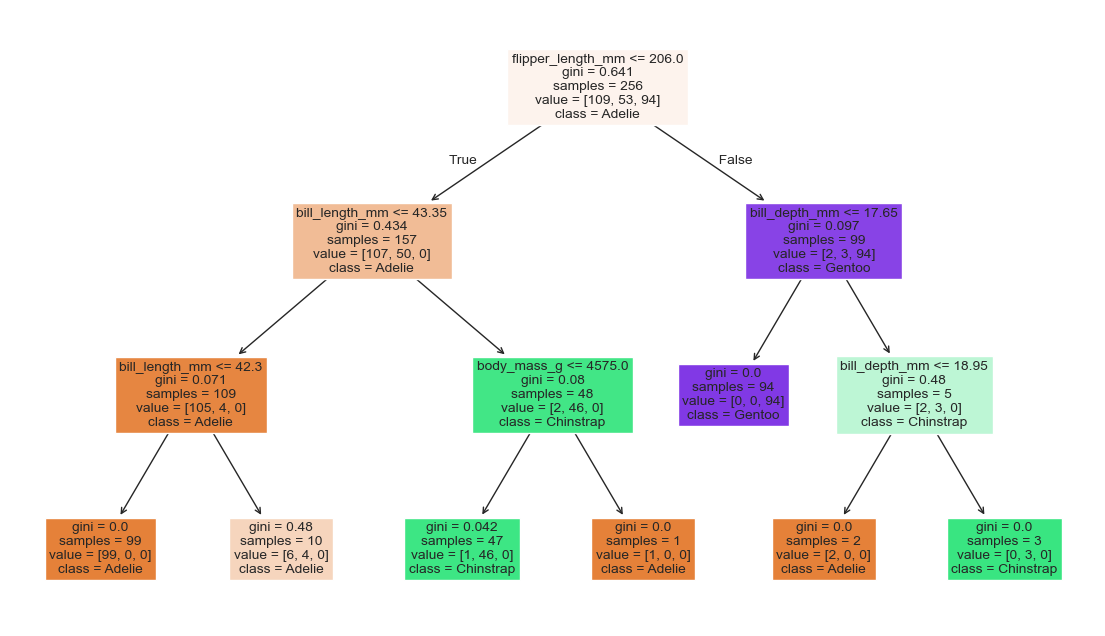

In [54]:
plt.figure(figsize=[14,8])
tree.plot_tree(
    clf,
    feature_names=x.columns,
    class_names=['Adelie', 'Chinstrap', 'Gentoo'],
    filled=True
)
plt.show()

#### Pós-poda

Para tal utilizaremos uma árvore sem limitações

In [56]:
caminho = DecisionTreeClassifier(random_state=2360873).cost_complexity_pruning_path(x_train, y_train)
# Obtendo ccp_alphas e impurezas
ccp_alphas, impurities = caminho.ccp_alphas, caminho.impurities

In [57]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=2360873, ccp_alpha=ccp_alpha)
    clf.fit(x_train, y_train)
    clfs.append(clf)

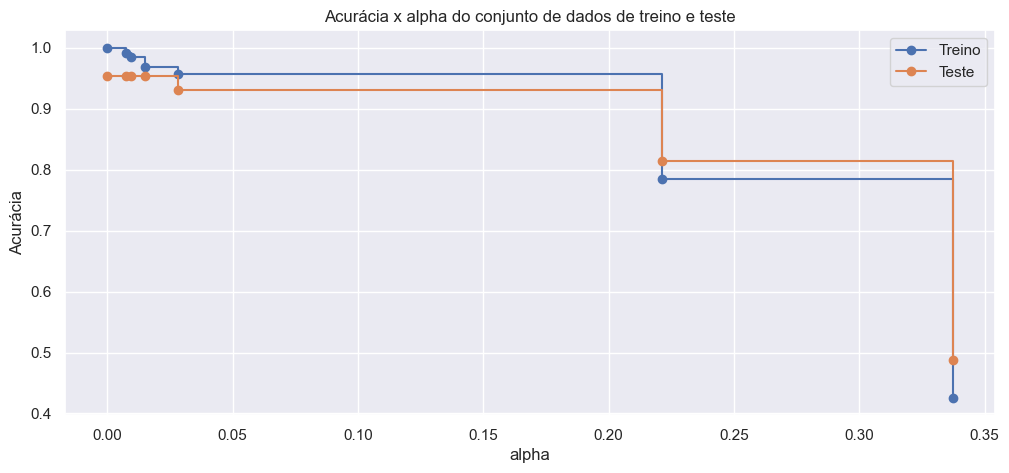

In [58]:
train_scores = [clf.score(x_train, y_train) for clf in clfs]
test_scores = [clf.score(x_test, y_test) for clf in clfs]

sns.set_theme(style='darkgrid')
fig, ax = plt.subplots(figsize=[12,5])
ax.set_xlabel('alpha')
ax.set_ylabel('Acurácia')
ax.set_title('Acurácia x alpha do conjunto de dados de treino e teste')
ax.plot(ccp_alphas, train_scores, marker='o', label='Treino', drawstyle='steps-post')
ax.plot(ccp_alphas, test_scores, marker='o', label='Teste', drawstyle='steps-post')
ax.legend()
plt.show()

#### Selecionando a melhor árvore

In [60]:
# Selecionando o melhor/maior valor (da direira para a esquerda)
ind_melhor_arvore = len(test_scores) - test_scores[::-1].index(max(test_scores)) - 1 
# -1 resulta o index de maior acurácia da direita para esquerda, caso haja empate
melhor_arvore = clfs[ind_melhor_arvore]
melhor_arvore

DecisionTreeClassifier(ccp_alpha=0.01505160550458716, random_state=2360873)

In [61]:
print(len(test_scores) )
print(test_scores[::1])
print(test_scores)
print(test_scores[::-1])
print(test_scores[::-1].index(max(test_scores)))

7
[0.9534883720930233, 0.9534883720930233, 0.9534883720930233, 0.9534883720930233, 0.9302325581395349, 0.813953488372093, 0.4883720930232558]
[0.9534883720930233, 0.9534883720930233, 0.9534883720930233, 0.9534883720930233, 0.9302325581395349, 0.813953488372093, 0.4883720930232558]
[0.4883720930232558, 0.813953488372093, 0.9302325581395349, 0.9534883720930233, 0.9534883720930233, 0.9534883720930233, 0.9534883720930233]
3


#### Avaliando o resultado

Agora vamos avaliar o resultado da nossa classificação utilizando a acurácia, na base de testes. Façamos uso da matriz de confusão para um visual um pouco melhor.

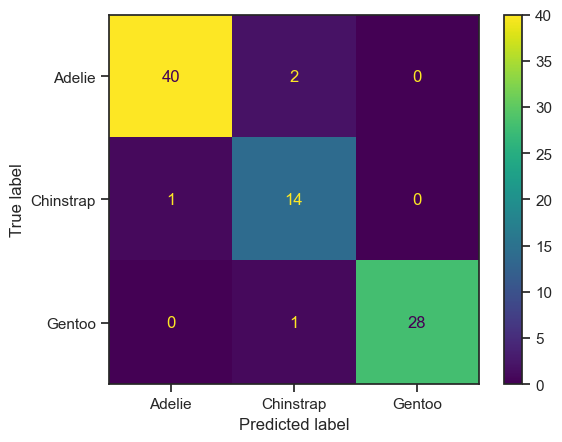

In [63]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

sns.set_theme(style='ticks')
predict = melhor_arvore.predict(x_test)
cm = confusion_matrix(y_test, predict, labels=melhor_arvore.classes_)
matrix = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=melhor_arvore.classes_)
# matrix = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['Adelie', 'Chinstrap', 'Gentoo'])
matrix.plot()
plt.show()

## 3 - Introdução ao cross-validation

*Machine learning "na veia"*

**Cross-validation**: Ato de tentar avaliar como o resultado de um modelo pode ser generalizado para uma população mais ampla; Uma técnica para avaliar a performance de modelos de *machine learn* em novos dados.

**Treino, validação e teste**

A *base de dados* será agora dividida em:
- *Treino*: Partição do conjunto de dados utilizada para desenvolver o algoritmo
- *Validação*: Partição utilizada para ajustes no algoritmo (*e.g.*: *post-pruning*)
- *Teste*: Partição utilizada para avaliar o desempenho do algoritmo "na prática"

O gancho da seção anterior (Classificação multinomial - Parte II):
- Será que "demos sorte" de a base de testes ter esse desempenho?
- Com outra base teriamos o mesmo desempenho?
- Como podemos obter uma métrica mais "confiável" do desempenho do algoritmo?

Como a base de testes foi utilizada para "tunar" o modelo, é razoável imaginarmos que ao aplicar o modelo a uma base mais ampla, não vamos obter exatamente esta mesma acurácia.

In [67]:
import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt

from sklearn.tree            import DecisionTreeClassifier
from sklearn.metrics         import accuracy_score
from sklearn.metrics         import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

#### Carregando base de dados

In [69]:
# Base de dados já tratada anteriormente (there's no missing data)
peng = pd.read_csv('peng.csv')
peng.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
4,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male


In [70]:
peng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342 entries, 0 to 341
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            342 non-null    object 
 1   island             342 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                342 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.8+ KB


#### Base de treino, validação e teste

Vamos separa 20% da base para testes (*holdout*) e 20% da base para validação. Os 60% restantes vamos utilizar para a base de treino.

In [72]:
# Separando os dados e removendo a coluna island

X = pd.get_dummies(peng.drop(columns=['island', 'species']), drop_first=True)
y = peng['species']

# Dados de teste
X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=2360873)
# Separando em treino e validação utilizando o train_test_split()
X_train, X_valid, y_train, y_valid = train_test_split(X_, y_, test_size=.25, random_state=2360873)

In [73]:
X_train.shape, X_valid.shape, X_test.shape

((204, 5), (69, 5), (69, 5))

In [74]:
X_train.size, X_valid.size, X_test.size

(1020, 345, 345)

#### Cálculo do `ccp_alpha`

In [76]:
clf = DecisionTreeClassifier(random_state=2360873)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [77]:
ccp_alphas

array([0.        , 0.00475779, 0.00484218, 0.00784314, 0.00897182,
       0.009368  , 0.03860294, 0.20356663, 0.33913298])

In [78]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=2360873, ccp_alpha = ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

In [79]:
clfs

[DecisionTreeClassifier(random_state=2360873),
 DecisionTreeClassifier(ccp_alpha=0.004757785467128027, random_state=2360873),
 DecisionTreeClassifier(ccp_alpha=0.004842180774748932, random_state=2360873),
 DecisionTreeClassifier(ccp_alpha=0.007843137254901959, random_state=2360873),
 DecisionTreeClassifier(ccp_alpha=0.008971824023727133, random_state=2360873),
 DecisionTreeClassifier(ccp_alpha=0.009367997678654906, random_state=2360873),
 DecisionTreeClassifier(ccp_alpha=0.038602941176470576, random_state=2360873),
 DecisionTreeClassifier(ccp_alpha=0.20356663143691694, random_state=2360873),
 DecisionTreeClassifier(ccp_alpha=0.33913297925115665, random_state=2360873)]

#### Obtendo a melhor árvore

Para realizar essa análise, agora utilizaremos a base de **validação** e não mais a de *testes*. 

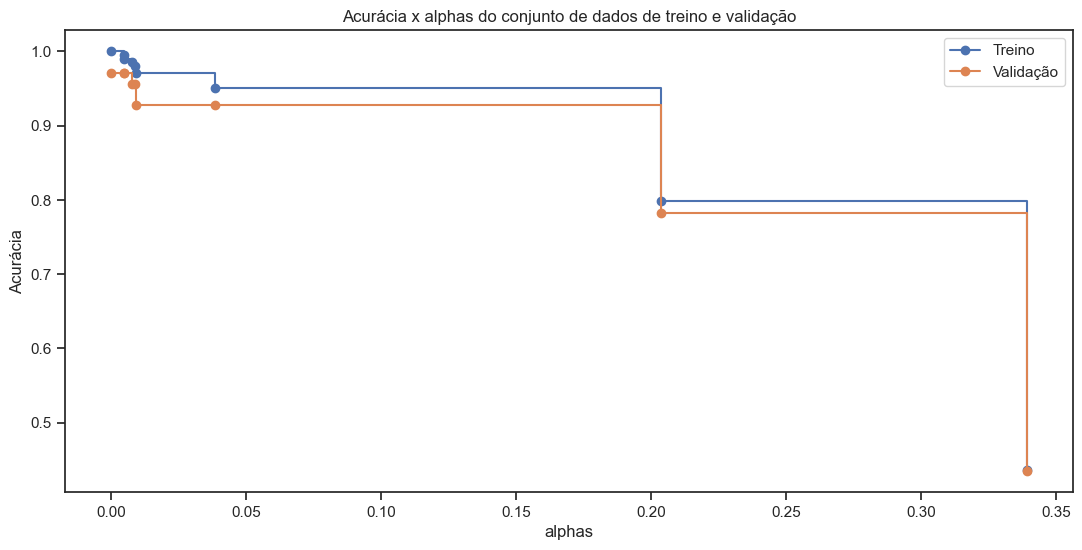

In [81]:
# Calculando o score
train_score = [clf.score(X_train, y_train) for clf in clfs]
valid_score = [clf.score(X_valid, y_valid) for clf in clfs]

fig, ax = plt.subplots(figsize=[13,6])
ax.set_xlabel('alphas')
ax.set_ylabel('Acurácia')
ax.set_title('Acurácia x alphas do conjunto de dados de treino e validação')
ax.plot(ccp_alphas, train_score, marker='o', drawstyle='steps-post', label='Treino')
ax.plot(ccp_alphas, valid_score, marker='o', drawstyle='steps-post', label='Validação')
ax.legend()
plt.show()

In [82]:
# Obtendo a árvore de melhor acurácia
ind_melhor_arvore = len(valid_score) - valid_score[::-1].index(max(valid_score)) - 1
melhor_arvore = clfs[ind_melhor_arvore]

print('A acurácia da melhor árvorena base de validação: {:.2f}'.format(valid_score[ind_melhor_arvore]*100))

melhor_arvore

A acurácia da melhor árvorena base de validação: 97.10


DecisionTreeClassifier(ccp_alpha=0.004842180774748932, random_state=2360873)

In [83]:
# Testando com meu método

df_score = pd.DataFrame({"ccp_alpha":ccp_alphas, 'valid_score':valid_score, 'train_score':train_score})
# Selecionando o melhor score de validação 
best_tree = df_score[df_score.valid_score == df_score.valid_score.max()]
# Selecionando o melhor alpha e seu index
best_alpha = best_tree.ccp_alpha[:-1]
best_alpha_index = best_tree.index[-1]
# Melhor árvore
best_tree = clfs[best_alpha_index]

print('A acurácia da melhor árvorena base de validação: {:.2f}'.format(valid_score[best_alpha_index]*100))
best_tree

# ---> Obtermos o mesmo retorno
# É importante notar a inversão da lista, pois pegamos o maior score da direita para a esquerda

A acurácia da melhor árvorena base de validação: 97.10


DecisionTreeClassifier(ccp_alpha=0.004842180774748932, random_state=2360873)

#### Avaliando a melhor árvore

Vamos verificar se essa acurácia se sustenta na base de testes.

--> Acurácia: 97.10


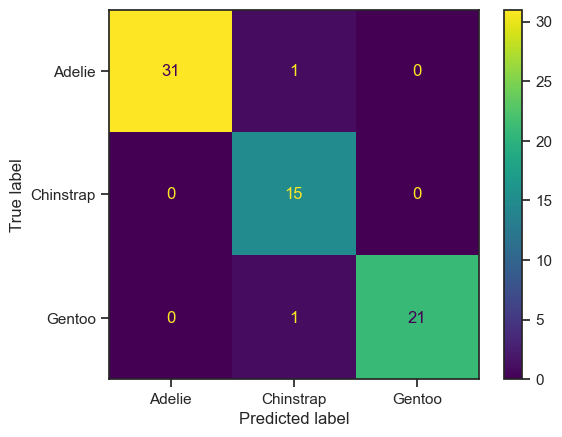

In [85]:
acuracia_teste = melhor_arvore.score(X_test, y_test)
print('--> Acurácia: {:.2f}'.format(acuracia_teste*100))

# Matriz de confusão
ConfusionMatrixDisplay.from_estimator(melhor_arvore, X_test, y_test)
plt.show()

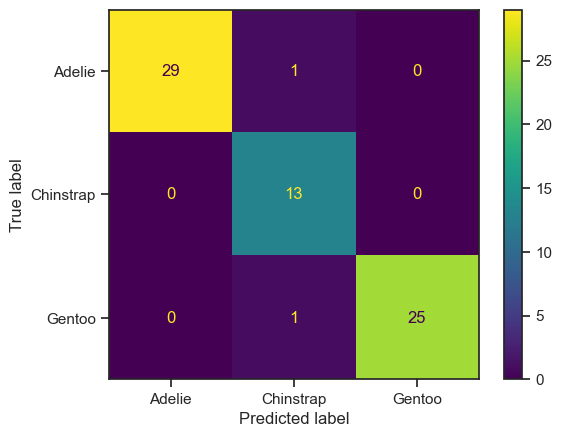

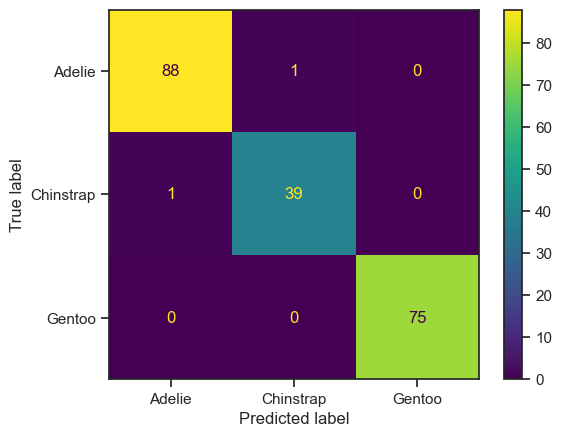

In [86]:
# Matriz de confusão para a base de validação
ConfusionMatrixDisplay.from_estimator(melhor_arvore, X_valid, y_valid)
plt.show()

# Matriz de confusão para a base de treino
ConfusionMatrixDisplay.from_estimator(melhor_arvore, X_train, y_train)
plt.show()

**Os resultado são mais consistente e confiáveis, uma vez que passaram por uma *cross-validation* (treino, validação e teste).**

## 4 - Tipos de *cross-validation*

- (Tipos) Exaustivos:
  - Leave one out;
  - Leave k out.
- (Tipos) Não exaustivos:
  - Holdout;
  - K-fold;
  - Sub-amostragem sequencial (ou reamostragem sequencial).
- (Tipos) Hierárquicos:
  - K-fold com holdout;
  - K-l-fold.

### K-fold com holdount

In [91]:
import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt

from sklearn.tree            import DecisionTreeClassifier
from sklearn.metrics         import accuracy_score
from sklearn.metrics         import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

- O que aconteceria se tivessemos pego outra base de testes?
- Será que essa base de testes não propicia casualmente uma acurácia maior ou menor?
- Já estamos 'perdendo' 20% da base para teste, perdemos outros 20% para validação, não podemos minimizar isso?

Vamos abordar as perguntas acima com as técnicas de validação cruzada que acabamos de ver.

A estratégia é a seguinte: 
- Separar uma base de testes (também chamada de *holdout*)
- Obter os caminhos de poda com o ```ccp_alpha``` da maior árvore possível
- Encontrar a melhor poda pela estratégia *k-fold* de *cross-validation* para cada *ccp-alpha*:
    - dividir a base de treinamento em k-grupos (chamados *folds*)
    - Para cada grupo j, pertencente aos k-grupos:
        - treinar uma árvore com com o ccp-alpha da vez, utilizando todas as observações, menos as do grupo j
        - avaliar a métrica dessa árvore utilizando o grupo j como base de validação
    - Escolher a árvore com melhor métrica nas bases de validação
- Após escolher a melhor configuração do modelo, vamos rodar novamente o modelo nessa configuração com todos os dados (exceto os de teste)
- Avaliar o modelo na base de teste.

Pronto, este é o nosso modelo final.

##### Carregando a base de dados

In [94]:
peng = pd.read_csv('peng.csv')
peng.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
4,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male


##### Separando a base de testes

Neste momento vamos separar apenas uma base de testes (chamada de *holdout*, pois é "mantida de fora" do processo).

In [96]:
# Separando em variáveis explicativas e target
X = pd.get_dummies(peng.drop(columns=['island', 'species']), drop_first=True)
y = peng.species

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=2360873)

##### Obter os caminhos de poda via ccp_alphas

In [98]:
clf = DecisionTreeClassifier(random_state = 2360873)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [99]:
# Não há valores negativos...
ccp_alphas

array([0.        , 0.00362909, 0.00549451, 0.00752508, 0.01046572,
       0.01391639, 0.03817082, 0.19371502, 0.33744331])

In [100]:
# Garantindo que os ccp_alphas são números positivos 
# Pode ser útil quando há um número muito grande de ccp_alphas

ccp_alphas = np.unique(ccp_alphas[ccp_alphas>=0])
ccp_alphas

array([0.        , 0.00362909, 0.00549451, 0.00752508, 0.01046572,
       0.01391639, 0.03817082, 0.19371502, 0.33744331])

#### <span style='color:purple'> *K-fold* com *holdout*

Eu sei que você saberia rodar o *grid_search* "na mão", mas vamos usar uma função do scikitlearn que faz tudo isso pra nós, o ```GridSearchCV()```. Observe que o CV no nome significa *cross validation*. Essa funão faz exatamente o que precisamos: um *grid-search*, com uma avaliação das possibilidades com *cross validation*. Vamos entender como os parâmetros:

``` python
GridSearchCV(
    estimator,
    param_grid,
    scoring=None, # Pode ser utilizado como métrica de avalição de qualidade do modelo (por padrão a acurácia é utilizada)
    cv=None
)
```
- **estimator**: aqui indicamos qual modelo vamos utilizar.
- **param_grid**: esse vai ser um dicionário, em que a chave é o nome dos hiperparâmetros e o valor vai ser uma lista com as possibilidades que queremos testar.
- **scoring**: vai ser a métrica de avaliação de performance do nosso modelo. No caso vamos usar a acurácia.
- **CV**: Este parâmetro, se especificado como um inteiro, é o *k* do *k-fold*. 

In [102]:
# Estimator
clf = DecisionTreeClassifier(random_state=2360873)
clf

DecisionTreeClassifier(random_state=2360873)

In [103]:
# param_grid
grid_parametros = {'ccp_alpha': ccp_alphas} # a chave dever ser uma parâmetro do estimator
grid_parametros

{'ccp_alpha': array([0.        , 0.00362909, 0.00549451, 0.00752508, 0.01046572,
        0.01391639, 0.03817082, 0.19371502, 0.33744331])}

In [104]:
# Difinindo o grid

grid = GridSearchCV(
    estimator = clf,
    param_grid = grid_parametros,
    cv = 15, # Será feito um k-fold de k = 15, base é dividida em 15 grups e um será "tirado" para validação (repete nos 15 grupos)
    verbose = 100 # Parâmetro para visualizar o output interativamente 
)

grid.fit(X_train, y_train)

Fitting 15 folds for each of 9 candidates, totalling 135 fits
[CV 1/15; 1/9] START ccp_alpha=0.0..............................................
[CV 1/15; 1/9] END ...............ccp_alpha=0.0;, score=0.842 total time=   0.0s
[CV 2/15; 1/9] START ccp_alpha=0.0..............................................
[CV 2/15; 1/9] END ...............ccp_alpha=0.0;, score=0.789 total time=   0.0s
[CV 3/15; 1/9] START ccp_alpha=0.0..............................................
[CV 3/15; 1/9] END ...............ccp_alpha=0.0;, score=0.947 total time=   0.0s
[CV 4/15; 1/9] START ccp_alpha=0.0..............................................
[CV 4/15; 1/9] END ...............ccp_alpha=0.0;, score=0.944 total time=   0.0s
[CV 5/15; 1/9] START ccp_alpha=0.0..............................................
[CV 5/15; 1/9] END ...............ccp_alpha=0.0;, score=0.944 total time=   0.0s
[CV 6/15; 1/9] START ccp_alpha=0.0..............................................
[CV 6/15; 1/9] END ...............ccp_alpha=0.0

GridSearchCV(cv=15, estimator=DecisionTreeClassifier(random_state=2360873),
             param_grid={'ccp_alpha': array([0.        , 0.00362909, 0.00549451, 0.00752508, 0.01046572,
       0.01391639, 0.03817082, 0.19371502, 0.33744331])},
             verbose=100)

> **Note que há 15 árvore para cada valor de ccp_alpha uma vez que condicionamos a cross-validation (cv) igual a 15.**

In [106]:
grid

GridSearchCV(cv=15, estimator=DecisionTreeClassifier(random_state=2360873),
             param_grid={'ccp_alpha': array([0.        , 0.00362909, 0.00549451, 0.00752508, 0.01046572,
       0.01391639, 0.03817082, 0.19371502, 0.33744331])},
             verbose=100)

In [107]:
# Resumo dos resultados pelo cv_results_

resultados = pd.DataFrame(grid.cv_results_) # Atributo para resumir o que foi feito pela função
resultados

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ccp_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002333,0.000471,0.001669,0.000474,0.000000,{'ccp_alpha': 0.0},0.842105,0.789474,0.947368,0.944444,...,1.000000,1.000000,1.000000,1.000000,0.944444,0.944444,0.944444,0.953411,0.060496,4
1,0.002636,0.000536,0.001267,0.000437,0.003629,{'ccp_alpha': 0.003629086962420302},0.842105,0.789474,0.947368,0.944444,...,1.000000,1.000000,1.000000,1.000000,0.944444,0.944444,0.944444,0.953411,0.060496,4
2,0.002308,0.000442,0.001463,0.000499,0.005495,{'ccp_alpha': 0.005494505494505495},0.842105,0.894737,0.947368,0.944444,...,1.000000,1.000000,1.000000,1.000000,0.944444,0.944444,0.944444,0.960429,0.045259,1
3,0.002799,0.000979,0.001400,0.000485,0.007525,{'ccp_alpha': 0.0075250836120401374},0.894737,0.894737,0.947368,0.888889,...,1.000000,1.000000,1.000000,1.000000,0.944444,0.944444,0.944444,0.960234,0.041555,2
4,0.002272,0.000447,0.001368,0.000464,0.010466,{'ccp_alpha': 0.010465724751439037},0.894737,0.894737,0.947368,0.888889,...,1.000000,1.000000,1.000000,1.000000,0.944444,0.944444,0.944444,0.960234,0.041555,2
5,0.002198,0.000401,0.001535,0.000502,0.013916,{'ccp_alpha': 0.013916392767933371},0.894737,0.947368,0.947368,0.888889,...,1.000000,0.944444,0.944444,1.000000,0.944444,0.944444,0.888889,0.952632,0.039232,6
6,0.002530,0.000621,0.001470,0.000503,0.038171,{'ccp_alpha': 0.03817082388510958},0.842105,0.894737,0.894737,0.833333,...,1.000000,0.944444,0.944444,0.944444,0.944444,0.944444,0.888889,0.930994,0.053892,7
7,0.002369,0.000472,0.001868,0.000617,0.193715,{'ccp_alpha': 0.19371501717135625},0.842105,0.894737,0.894737,0.833333,...,0.833333,0.944444,0.944444,0.777778,0.777778,0.777778,0.888889,0.853216,0.052796,8
8,0.002399,0.000489,0.001201,0.000400,0.337443,{'ccp_alpha': 0.33744330557517377},0.736842,0.789474,0.789474,0.777778,...,0.444444,0.444444,0.444444,0.777778,0.444444,0.444444,0.722222,0.572904,0.158207,9


In [108]:
# Ranking dos melhores ccp_alphas
resultados.rank_test_score

0    4
1    4
2    1
3    2
4    2
5    6
6    7
7    8
8    9
Name: rank_test_score, dtype: int32

In [109]:
# Função para o melhor índice
grid.best_index_

2

In [110]:
# Melhor estimator
grid.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.005494505494505495, random_state=2360873)

In [111]:
# O melhores parêmetros
grid.best_params_

# Só colocamos o ccp_alpha, mas caso hajam mais parâmetros eles serão apresentados aqui

{'ccp_alpha': 0.005494505494505495}

In [112]:
# best_score
grid.best_score_

0.9604288499025342

##### Modelo final

Ajustando o modelo final com o ccp_alpha que oferece o melhor resultado

In [114]:
melhor_ccp = resultados.iloc[grid.best_index_, 4] 
# 4 indica a coluna do parâmetro de interesse ccp_alpha

# Ajustando o modelo
clf = DecisionTreeClassifier(ccp_alpha=melhor_ccp, random_state=2360873).fit(X_train, y_train)
clf

DecisionTreeClassifier(ccp_alpha=0.005494505494505495, random_state=2360873)

In [115]:
# A acurácia nos dados de teste

print('O modelo obteve uma acurácia de {:.2f}%.'.format(clf.score(X_test, y_test)*100))

O modelo obteve uma acurácia de 98.55%.


### Conclusão

- O resultado final na base de testes está bem razoável e dentro da expectativa de *cross-validation* - próximo da acurácia média, em comparação com o erro padrão.
- Essas técnicas de validação cruzada podem demandar um certo esforço computacional. Dependendo do tamanho da base e do número de variáveis pode tomar um tempo representativo e pode demandar um planejamento mais cuidadoso.

### 8. Referências

- [Documentação do scikitlearn](https://scikit-learn.org/stable/modules/cross_validation.html)

- "An Introduction to Statistical Learning" Gareth M. James, Daniela Witten, Trevor Hastie, R J Tibshirani (disponível [aqui](https://www.statlearning.com/))